In [3]:
# load libraries
import numpy as np
import pandas as pd 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')
from tqdm.notebook import tqdm
from datetime import datetime
import re
import time
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
# Load customer feedback data from kaggle dataset
df = pd.read_csv("../input/twitter-customer-messages/twcs.csv")
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


#--------------------------------------------------------Sentiment Analysis------------------------------------------------------




---



In [5]:
print('shape: ',df.shape)
print('Columns: ',df.columns)

shape:  (2811774, 7)
Columns:  Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')


In [6]:
# Focus only on messages/complaints from customers i.e inbound tweets only
customer_msg = df[df.inbound]
customer_msg.shape

(1537843, 7)

In [7]:
# Original dataset includes support data from multiple companies. Here we choose one of the companies for instace Sprint in this case.
customer_msg = customer_msg[customer_msg['text'].str.contains("sprintcare")]
print(customer_msg.shape)
customer_msg.head()

(13714, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0


In [8]:
# Find duplicates
print(len(customer_msg.index))#13714
serlis=customer_msg.duplicated().tolist()
print(serlis.count(True))#0
serlis=customer_msg.duplicated(['text']).tolist()
print(serlis.count(True))#324

13714
0
324


In [9]:
# Drop duplicates
customer_msg.drop_duplicates(['text'],inplace=True)
customer_msg.reset_index(drop=True,inplace=True)
customer_msg.shape

(13390, 7)

In [10]:
# Enable progress bar on processing
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
# BASIC CLEANING FUNCTION
def clean_text(text):
    txt = text
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#username-tags
    txt=re.sub(r'^[RT]+','',txt)#RT-tags
    txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#URLs
    txt=re.sub("[^a-zA-Z]", " ",txt)#hashtags
    return(txt)

customer_msg.text = customer_msg.text.progress_apply(clean_text) 
customer_msg.head()   

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,and how do you propose we do that,NaN,1.0
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,I have sent several private messages and no o...,1,4.0
2,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,I did,4,6.0
3,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,is the worst customer service,"9,6,10",NaN
4,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,You gonna magically change your connectivity ...,"11,13,14",15.0


In [14]:
# Change data type to be datetime for column "created_at" and
# sort by the ascending order so we can analize the messages based on the time when they are created 
customer_msg['created_at'] = pd.to_datetime(customer_msg.created_at)
customer_msg = customer_msg.sort_values(by='created_at')

In [15]:
# Instantiate sentiment analyzer from NLTK, make "sentiment_analyze" function
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_analyze(text: str) -> float:
    return sentiment_analyzer.polarity_scores(text)['compound']

In [16]:
# Analyze customer sentiment based on their messages
customer_msg['sentiment'] = \
    customer_msg.text.progress_apply(sentiment_analyze)

In [18]:
positive = len(customer_msg[customer_msg['sentiment']>0])
negative = len(customer_msg[customer_msg['sentiment']<0])
neutral = len(customer_msg[customer_msg['sentiment']==0])
temp = pd.DataFrame({'Sentiment':['Positive', 'Neutral', 'Negative'],'No. of Customers':[positive,neutral,negative]})
import plotly.express as px
fig = px.bar(temp,x='Sentiment', y='No. of Customers',
             color='Sentiment',title= 'Sprintcare customer sentiments' )
fig.show()

In [19]:
# Group by author_id so we can deal with messages from different customers(author_id)
customer_grouped = customer_msg.groupby('author_id')

## Usecase 1

In [20]:
# Case 1, we can calculate average sentiment values for each customer over this data chunk
# and compare to predefined alert threshold. 
# If the average sentiment value is lower than the threshold we'll list all the customers(author_id) 
# and suggest to reach to them for further discussion to find the reason and resolve the issues proactively
author_sentiment_avg = customer_grouped.sentiment.mean().sort_values()
author_sentiment_avg_df = pd.DataFrame({'author_id':author_sentiment_avg.index, 'sentiment':author_sentiment_avg.values})
alert_threshold_avg = -0.7
author_sentiment_avg_df[author_sentiment_avg_df.sentiment <= alert_threshold_avg]

,author_id,sentiment
0,397327,-0.9520
1,494819,-0.9419
2,421239,-0.9348
3,221558,-0.9315
4,467207,-0.9300
...,...,...
200,459367,-0.7003
201,229243,-0.7003
202,196571,-0.7003
203,659286,-0.7003


In [21]:
# Five point summary box plot and distribution plots for negative average sentiment scores of customers
import plotly.express as px
import plotly.figure_factory as ff
temp = author_sentiment_avg_df[author_sentiment_avg_df['sentiment']<0]
fig = px.box(temp, y="sentiment", points="all")
fig.show()

hist_data = [temp['sentiment']]
group_labels = ['Dist. of average negative sentiments of customers'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

## Usecase 2

In [22]:
# Case 2, we can find the minimum sentiment values for each customer over this data chunk
# and compare to predefined alert threshold. 
# If the minimum sentiment value is lower than the threshold we'll list all the customers(author_id) 
# and suggest to reach to them for further discussion to find the reason and resolve the issues proactively
author_sentiment_lowest = customer_grouped.sentiment.min().sort_values()
author_sentiment_lowest_df = pd.DataFrame({'author_id':author_sentiment_lowest.index, 'sentiment':author_sentiment_lowest.values})
alert_threshold_min = -0.8
author_sentiment_lowest_df[author_sentiment_lowest_df.sentiment <= alert_threshold_min]

,author_id,sentiment
0,221558,-0.9741
1,463642,-0.9594
2,164264,-0.9571
3,189882,-0.9554
4,766600,-0.9524
...,...,...
234,576163,-0.8020
235,478297,-0.8020
236,134203,-0.8020
237,203121,-0.8016


In [23]:
# Five point summary box plot and distribution plots for negative average sentiment scores of customers
import plotly.express as px
import plotly.figure_factory as ff
temp = author_sentiment_lowest_df[author_sentiment_lowest_df['sentiment']<0]
fig = px.box(temp, y="sentiment", points="all")
fig.show()

hist_data = [temp['sentiment']]
group_labels = ['Dist. of min. sentiment scores of customers'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

#--------------------------------------------------------Topic Modelling------------------------------------------------------




---



In [24]:
!pip install --upgrade pycaret
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

     |████████████████████████████████| 251 kB 603 kB/s eta 0:00:01
     |████████████████████████████████| 259 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 27.8 MB/s eta 0:00:01


     |████████████████████████████████| 326 kB 32.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 35.0 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 4.1 MB/s  eta 0:00:01
     |████████████████████████████████| 77 kB 4.7 MB/s  eta 0:00:01
     |████████████████████████████████| 2.1 MB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 121 kB 37.5 MB/s eta 0:00:01


     |████████████████████████████████| 45 kB 2.0 MB/s  eta 0:00:01
  Created wheel for pyod: filename=pyod-0.8.2-py3-none-any.whl size=110196 sha256=6943995dacae602177f14998821e9c6d2af9fbfe5e43c7aaa9f388286e90885f
  Stored in directory: /root/.cache/pip/wheels/07/8d/4a/73b69c4a2ffa4ff4a5347c43afb43c48871465a1211e22d117
  Created wheel for querystring-parser: filename=querystring_parser-1.2.4-py3-none-any.whl size=7076 sha256=605f60cf0f9e165100f658bf7ebfa474da0f3b8770158cd2a3b7a1dc3b2886e2
  Stored in directory: /root/.cache/pip/wheels/69/38/7a/072b5863ca334d012821a287fd1d066cea33abdcda3ef2f878
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.13-cp37-cp37m-linux_x86_64.whl size=1221867 sha256=1374d81f770cc000479ac577a0886fec98be80dae121c41761bc107adcdde3d7
  Stored in directory: /root/.cache/pip/wheels/b9/ba/77/163f10f14bd489351530603e750c195b0ceceed2f3be2b32f1


  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=78b62cd9731c361a504bc561eb8733b3ac39d36a2570e7032ad42cda6fc8af86
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.16.0-py3-none-any.whl size=16766 sha256=6c79333b2d2616c28a3b848f9ee3456379429355c20a6d7e0dbdebc981b57ac4
  Stored in directory: /root/.cache/pip/wheels/e5/40/22/76614a1933bd6baa74bab7b5132f614ea47b7fb69ee438fe7f
  Created wheel for databricks-cli: filename=databricks_cli-0.11.0-py3-none-any.whl size=90300 sha256=20fe988a4b0290c3785d4d056ae4bc56d8298dc2c016f9e3101e8df7fdf1f725
  Stored in directory: /root/.cache/pip/wheels/81/3f/18/5678c9d403583e583a251463196998b17852b98de34aa9ab51
  Created wheel for combo: filename=combo-0.1.1-py3-none-any.whl size=42113 sha256=53dd26e65f89688e05a09868f9314024a9e27088c378351b0e1964ef29250ee0
  Stored in direct

In [25]:
#import nlp module
from pycaret.nlp import *

In [26]:
customer_msg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13390 entries, 4969 to 2093
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   tweet_id                 13390 non-null  int64              
 1   author_id                13390 non-null  object             
 2   inbound                  13390 non-null  bool               
 3   created_at               13390 non-null  datetime64[ns, UTC]
 4   text                     13390 non-null  object             
 5   response_tweet_id        9278 non-null   object             
 6   in_response_to_tweet_id  10194 non-null  float64            
 7   sentiment                13390 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 850.0+ KB


In [27]:
customer_msg['text']=customer_msg['text'].values.astype('U')
customer_msg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13390 entries, 4969 to 2093
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   tweet_id                 13390 non-null  int64              
 1   author_id                13390 non-null  object             
 2   inbound                  13390 non-null  bool               
 3   created_at               13390 non-null  datetime64[ns, UTC]
 4   text                     13390 non-null  object             
 5   response_tweet_id        9278 non-null   object             
 6   in_response_to_tweet_id  10194 non-null  float64            
 7   sentiment                13390 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 850.0+ KB


In [29]:
# initialize the setup
nlp = setup(data = customer_msg, target = 'text')

Description,Value
session_id,3426
Documents,13390
Vocab Size,5094
Custom Stopwords,False


In [30]:
# create the model
lda = create_model('lda', num_topics = 5, multi_core = True)

In [31]:
# label the data using trained model
df_lda = assign_model(lda)

In [33]:
df_lda

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,sentiment,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Dominant_Topic,Perc_Dominant_Topic
0,2,115712,True,2017-10-31 22:11:45+00:00,propose,NaN,1.0,0.0000,0.228771,0.683113,0.029201,0.029309,0.029606,Topic 1,0.68
1,3,115712,True,2017-10-31 22:08:27+00:00,send several private message respond usual,1,4.0,-0.2960,0.022905,0.022463,0.146760,0.022709,0.785163,Topic 4,0.79
2,5,115712,True,2017-10-31 21:49:35+00:00,,4,6.0,0.0000,0.122879,0.016668,0.016755,0.827024,0.016674,Topic 3,0.83
3,8,115712,True,2017-10-31 21:45:10+00:00,bad customer service,"9,6,10",NaN,-0.6249,0.917571,0.020245,0.020808,0.020823,0.020554,Topic 0,0.92
4,12,115713,True,2017-10-31 22:04:47+00:00,go magically change connectivity whole family,"11,13,14",15.0,0.0000,0.050237,0.797605,0.051392,0.050220,0.050546,Topic 1,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13385,2984267,775845,True,2017-11-20 18:59:21+00:00,long draw process order include automate cance...,2984266,NaN,0.1027,0.025226,0.214706,0.709156,0.025399,0.025513,Topic 2,0.71
13386,2748003,201649,True,2017-11-20 21:58:37+00:00,cracked screen,2984731,2747999.0,0.0000,0.025190,0.025217,0.629969,0.025332,0.294291,Topic 2,0.63
13387,2984733,823042,True,2017-11-20 21:07:07+00:00,try deal problem day half hear garbage stuff a...,2984732,NaN,-0.2144,0.025096,0.388694,0.116805,0.318884,0.150521,Topic 1,0.39
13388,2987667,823780,True,2017-11-22 03:22:52+00:00,transfer crap note free space,NaN,2987666.0,0.1779,0.066737,0.732220,0.067053,0.067134,0.066856,Topic 1,0.73


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.178841 -0.195158       1        1  24.762319
0     -0.046034  0.202710       2        1  22.695781
3     -0.167575 -0.264379       3        1  19.027771
2     -0.256876  0.078921       4        1  18.492183
1      0.291644  0.177907       5        1  15.021946, topic_info=         Term         Freq        Total Category  logprob  loglift
11    service  1634.000000  1634.000000  Default  30.0000  30.0000
31      thank   697.000000   697.000000  Default  29.0000  29.0000
50   customer  1310.000000  1310.000000  Default  28.0000  28.0000
0        call  1230.000000  1230.000000  Default  27.0000  27.0000
128      send   635.000000   635.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
2         let    75.103280   175.670793   Topic5  -5.1117   1.0459
78       need    87.681162   587.172430   Topic5  -4.9568  -0.0060
133       fix    79.912085   361.068338   Topic5  -5.0496   0.3875
87      still    78.830595   635.986220   Topic5  -5.0633  -0.1922
3        make    77.082136   486.908596   Topic5  -5.0857   0.0525

[318 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
198       2  0.989891    access
199       2  0.565133   account
199       3  0.255144   account
199       4  0.178839   account
281       2  0.841116  activate
...     ...       ...       ...
307       4  0.240165     would
307       5  0.073271     would
28        1  0.574324      year
28        2  0.077611      year
28        3  0.348142      year

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 3, 2])

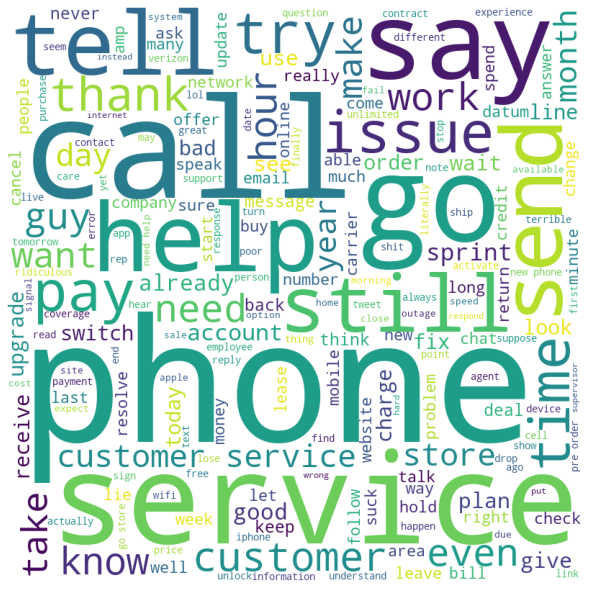

In [34]:
plot_model(lda, plot='topic_distribution')
plot_model(lda, plot='topic_model')
plot_model(lda, plot='wordcloud', topic_num = 'Topic 3')
plot_model(lda, plot='frequency', topic_num = 'Topic 3')
plot_model(lda, plot='bigram', topic_num = 'Topic 3')
plot_model(lda, plot='trigram', topic_num = 'Topic 3')
plot_model(lda, plot='distribution', topic_num = 'Topic 3')
plot_model(lda, plot='sentiment', topic_num = 'Topic 3')
plot_model(lda, plot='tsne')

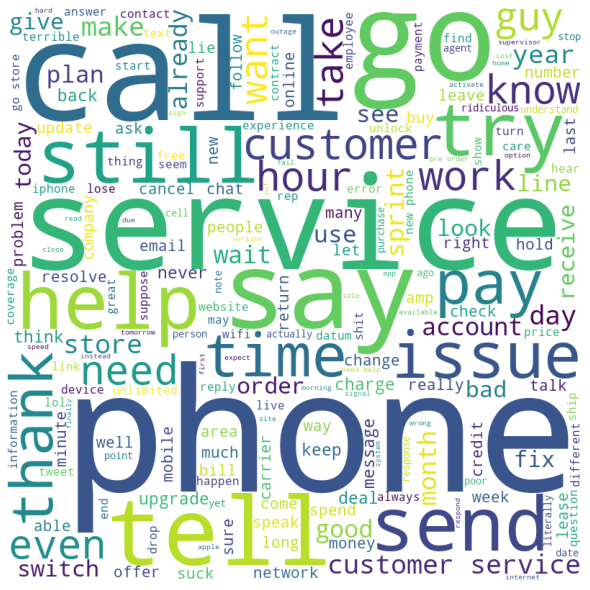

In [35]:
plot_model(lda, plot='wordcloud', topic_num = 'Topic 3')

In [36]:
evaluate_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…